In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moment
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from skimage import exposure
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from skimage.filters import  threshold_otsu
from sklearn.model_selection import train_test_split



# Ładowanie obrazów

In [3]:
image_names = ["01_h.jpg", "03_dr.jpg", "06_h.jpg", "14_g.jpg", "14_h.jpg"]
images = []
images_gray = []
images_mask = []

unlabeled_dir = 'obrazy/unlabeled/'
labeled_dir = 'obrazy/labeled_m/'
masks_dir = 'obrazy/masks/'

for image_name in image_names:
    image_name = image_name[:-4]
    image = cv.imread(unlabeled_dir + image_name + '.jpg')
    image_labeled = cv.imread(labeled_dir + image_name + '.tif')
    image_mask = cv.imread(masks_dir + image_name + '_mask.tif')

    image_gray = cv.cvtColor(image_labeled, cv.COLOR_BGR2GRAY)
    image_mask = cv.cvtColor(image_mask, cv.COLOR_BGR2GRAY)
    images.append(image)
    images_gray.append(image_gray)
    images_mask.append(image_mask)

## Wstępne przetworzenie

Podejściem dającym najlepsze rezultaty okazało się proste filtrowanie:
- Zabranie tylko kanału zielonego
- podniesienie kontrastu

Dalsze obróbki nie dawały widocznych poprawek w rezultacie

In [39]:
def process_images(images):
    rescaled_images = []
    for i, image in enumerate(images):
        image_green = image[:,:,1]
        image_green_contrast = exposure.equalize_hist(image_green)
        plt.imshow(image_green, cmap='gray')
        rescaled_images.append(image_green_contrast)
        plt.show()
    return rescaled_images


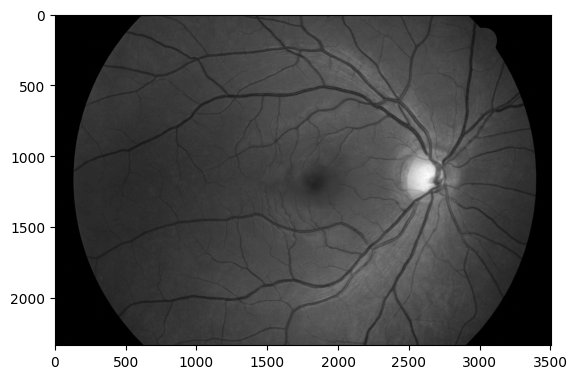

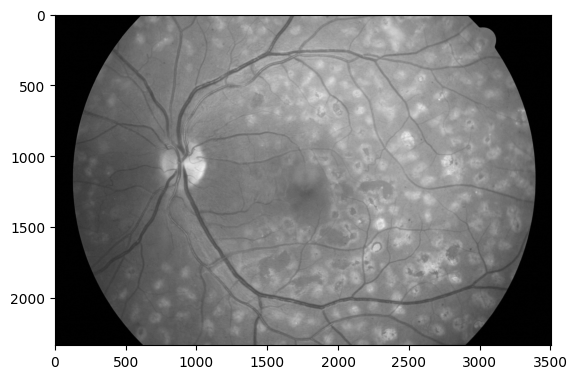

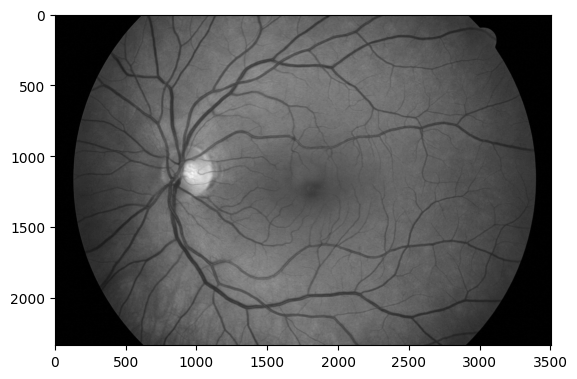

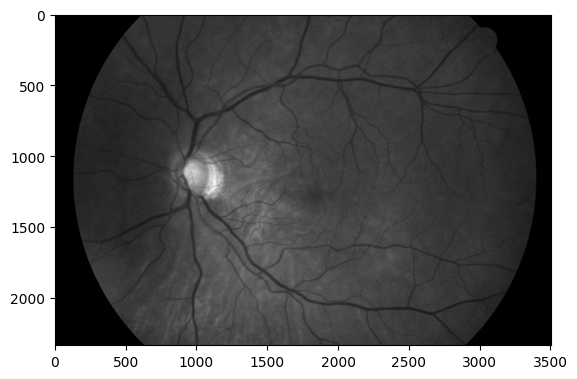

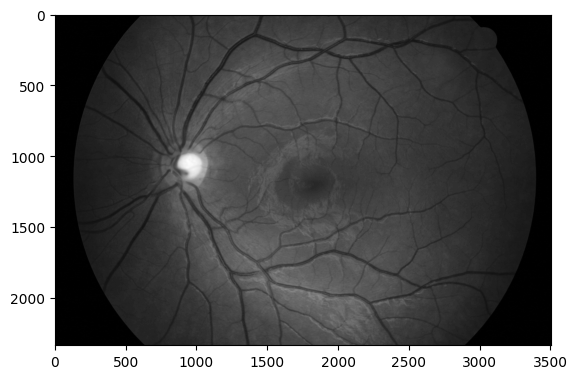

In [40]:
rescaled_images = process_images(images)

## Cechy do klasyfikatora
Nasz klasyfikator przyjmuje następujące cechy wycinka obrazu:
- wariancja
- średnia z koloru (jasności)
- moment centralny
- moment Hu

In [41]:
def calculate_central_moments(patch):
    return moment(patch.flatten(), moment=2)

def calculate_hu_moments(patch):
    moments = cv.moments(patch)
    hu_moments = cv.HuMoments(moments).flatten()
    return hu_moments

def extract_features(image, mask, step=5):
    height, width = image.shape[:2]
    features = []
    coordinates = []
    for y in range(0, height - step + 1, step):
        for x in range(0, width - step + 1, step):
            if mask is not None and (mask[y, x] < 126): continue

            patch = image[y:y+5, x:x+5]
            feature = [
                np.var(patch),
                np.mean(patch),
                calculate_central_moments(patch),
                *calculate_hu_moments(patch)
            ]
            features.append(feature)
            coordinates.append((x+2, y+2))
    return np.array(features), coordinates

## Etykiety dla klasyfikatora
Utworzenie listy etykiet dla klasyfikatora podobnie jak cech wykorzystuje maskowania - wykorzystujemy tylko te elementy obrazu, które nalezą do maski.

In [9]:
def extract_labels(labeled_image, mask, step=5):
    height, width = labeled_image.shape[:2]
    labels = []
    for y in range(0, height - step + 1, step):
        for x in range(0, width - step + 1, step):
            if mask is not None and (mask[y, x] < 126): continue

            patch = labeled_image[y:y+5, x:x+5]
            label = int(np.mean(patch) > 127)  # Thresholding at 127
            labels.append(label)
    return np.array(labels)

## Utworzenie zbioru treningowego i testowego
Wykorzystany rozmiar okna to 5x5 pikseli. Zbiór testowy stanowi 20% całości

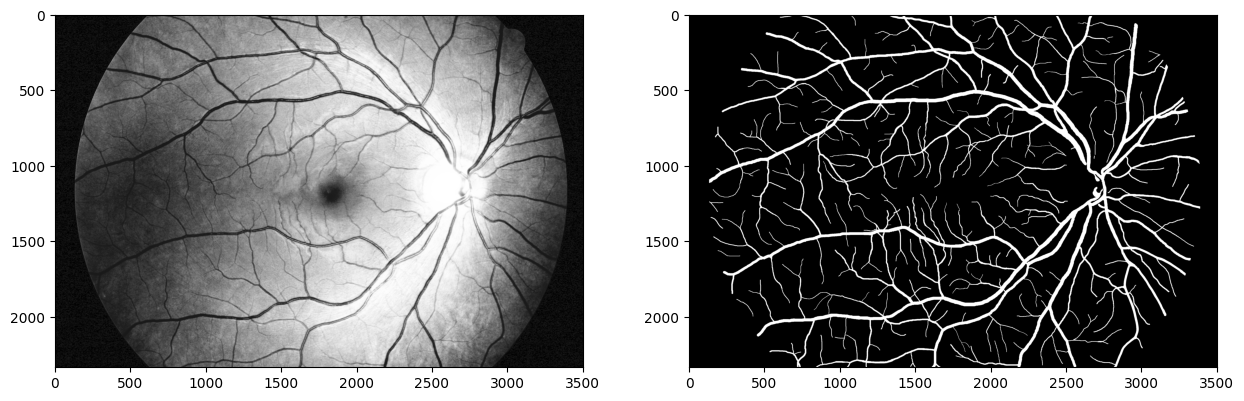

In [42]:
train1 = rescaled_images[0]
train_label1 = images_gray[0]
train_mask1 = images_mask[0]

features = extract_features(train1, train_mask1)[0]
labels = extract_labels(train_label1, train_mask1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=28)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(train1, cmap='gray')
axs[1].imshow(train_label1, cmap='gray')


plt.show()  

## Klasyfikator
Eksperymentowaliśmy z klasyfikatorami `KNeighborsClassifier` oraz `RandomForestClassifier`. Pierwszy działa bardzo szybko, ale rezultaty nie są zadowalające. \
`RandomForestClassifier` w połączeniu z `RandomizedSearchCV` (optymalizacja parametrów klasyfikatora) daje najlepsze rezultaty.\
 Parametry `n_estimators` oraz `n_iter` dostosowane są tak, aby zachować rozsądny czas wykonania - w tym przypadku < 10min

In [43]:
# Duzo szybsza wersja, gorsze rezultaty
# classifier = KNeighborsClassifier(n_neighbors=5)
# classifier.fit(X_train, y_train)

grid = dict(
    max_depth=np.arange(4, 20, 1),
    min_samples_leaf=np.linspace(0.005, 0.1, 100),
    min_samples_split=np.linspace(0.005, 0.1, 100))

classifier = RandomForestClassifier(
    n_estimators=400, max_features='sqrt',
    random_state=1234, n_jobs=-1)

classifier = RandomizedSearchCV(
    classifier, param_distributions=grid, n_iter=5, cv=5, scoring='f1',
    verbose=2, random_state=1234, n_jobs=-1)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=12, min_samples_leaf=0.02898989898989899, min_samples_split=0.08560606060606062; total time= 2.2min
[CV] END max_depth=12, min_samples_leaf=0.02898989898989899, min_samples_split=0.08560606060606062; total time= 2.2min
[CV] END max_depth=12, min_samples_leaf=0.02898989898989899, min_samples_split=0.08560606060606062; total time= 2.2min
[CV] END max_depth=16, min_samples_leaf=0.023232323232323233, min_samples_split=0.013636363636363637; total time= 2.4min
[CV] END max_depth=16, min_samples_leaf=0.023232323232323233, min_samples_split=0.013636363636363637; total time= 2.5min
[CV] END max_depth=16, min_samples_leaf=0.023232323232323233, min_samples_split=0.013636363636363637; total time= 2.5min
[CV] END max_depth=16, min_samples_leaf=0.023232323232323233, min_samples_split=0.013636363636363637; total time= 2.5min
[CV] END max_depth=16, min_samples_leaf=0.023232323232323233, min_samples_split=0.01363636363636363

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                                    random_state=1234),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'min_samples_leaf': array([0.005     , 0.0059596 , 0.00691919, 0.00787879, 0.00883838,
       0.00979798, 0.01075758, 0.01171717, 0.01267677, 0.01363636,
       0.01459596, 0.0...
       0.07217172, 0.07313131, 0.07409091, 0.07505051, 0.0760101 ,
       0.0769697 , 0.07792929, 0.07888889, 0.07984848, 0.08080808,
       0.08176768, 0.08272727, 0.08368687, 0.08464646, 0.08560606,
       0.08656566, 0.08752525, 0.08848485, 0.08944444, 0.09040404,
       0.09136364, 0.09232323, 0.09328283, 0.09424242, 0.09520202,
       0.09616162, 0.09712121, 0.09808081, 0.0990404 , 0.1       ])},
                   random_state=1234, scoring='f1', verbose=2)

In [22]:
def calculate_dice_coefficient(true_masks, predicted_masks):
    intersection = np.logical_and(true_masks, predicted_masks)
    dice_coefficient = 2.0 * intersection.sum() / (true_masks.sum() + predicted_masks.sum())
    return dice_coefficient

## Statystyki

In [46]:
predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))

dice_coefficient = calculate_dice_coefficient(np.array(y_test), predictions)
print("Dice Coefficient:", dice_coefficient)

Accuracy: 0.9137669102220937
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     48552
           1       0.66      0.60      0.63      6740

    accuracy                           0.91     55292
   macro avg       0.80      0.78      0.79     55292
weighted avg       0.91      0.91      0.91     55292

Dice Coefficient: 0.6302156041569722


## Wizualizacja

/var/folders/tq/lhny2rrn5z9dn_d14twtrql40000gn/T/ipykernel_37528/3491116605.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return moment(patch.flatten(), moment=2)


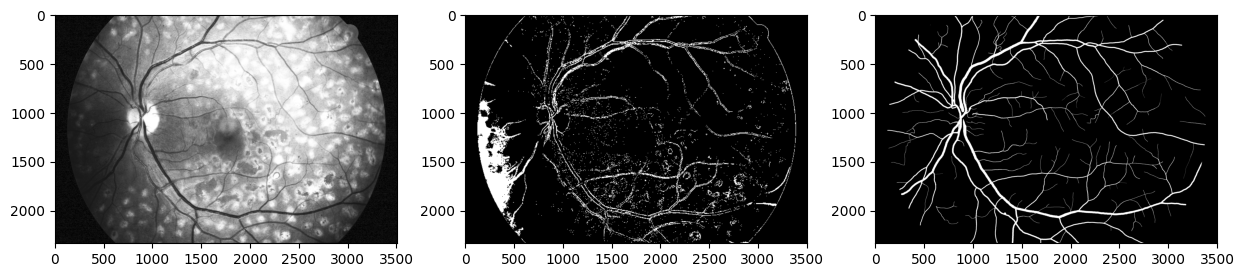

/var/folders/tq/lhny2rrn5z9dn_d14twtrql40000gn/T/ipykernel_37528/3491116605.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return moment(patch.flatten(), moment=2)


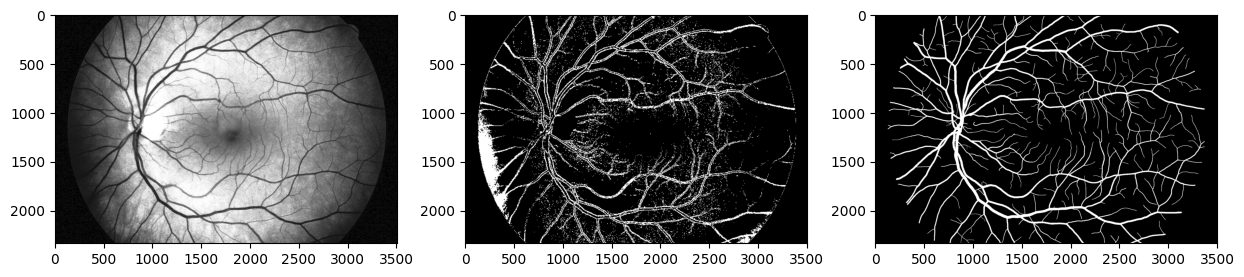

/var/folders/tq/lhny2rrn5z9dn_d14twtrql40000gn/T/ipykernel_37528/3491116605.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return moment(patch.flatten(), moment=2)


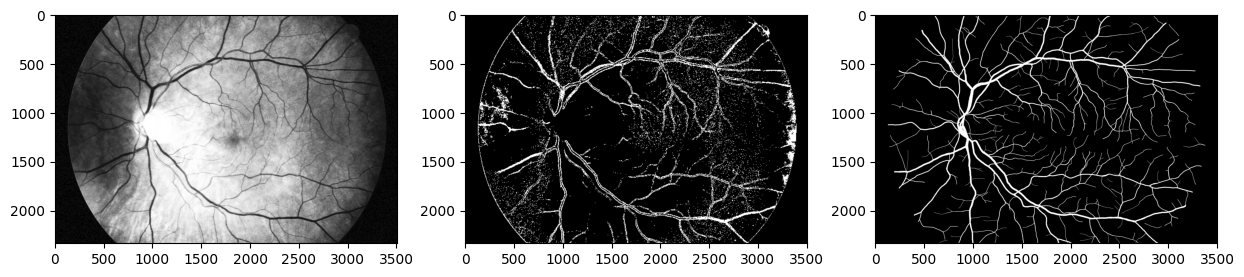

/var/folders/tq/lhny2rrn5z9dn_d14twtrql40000gn/T/ipykernel_37528/3491116605.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return moment(patch.flatten(), moment=2)


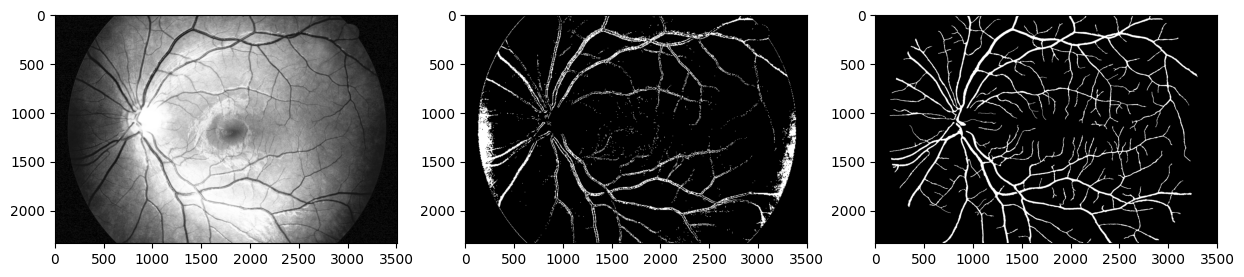

In [47]:
for i in range(1,5):
    test_image = rescaled_images[i]
    test_mask = images_mask[i]

    test_features, test_coordinates = extract_features(test_image, None)
    Y = classifier.predict(test_features)


    mask_predicted = np.zeros(test_image.shape, dtype=np.uint8)
    for coord, label in zip(test_coordinates, Y):
        x, y = coord
        
        if test_mask[y, x] < 126: mask_predicted[y:y+5, x:x+5] = 0
        else: mask_predicted[y:y+5, x:x+5] = label * 255

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))

    axs[0].imshow(rescaled_images[i], cmap='gray')
    axs[1].imshow(mask_predicted, cmap='gray')
    axs[2].imshow(images_gray[i], cmap='gray')
    plt.show()
